<a href="https://colab.research.google.com/github/Ashishxyz/HealthVision/blob/main/ModelSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing and Modelling

In [ ]:
!pip uninstall typeguard inflect tensorflow-addons -y
!pip install tensorflow-addons==0.23.0 typeguard==2.13.3 inflect==5.3.0

!pip install tensorflow==2.15.0

import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow version:", tf.__version__)
print("TensorFlow Addons version:", tfa.__version__)

!pip install lime

Found existing installation: typeguard 4.3.0
Uninstalling typeguard-4.3.0:
  Successfully uninstalled typeguard-4.3.0
Found existing installation: inflect 7.4.0
Uninstalling inflect-7.4.0:
  Successfully uninstalled inflect-7.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: m

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow version: 2.15.0
TensorFlow Addons version: 0.23.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6eb3b449d585c8fbdce5f8dc16563f27024e7409a99eb52fb0b057390410d81b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


# Imports

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,DenseNet121,ResNet50,InceptionV3,EfficientNetB3
import tensorflow_addons as tfa
from tensorflow.keras import layers
import tensorflow as tf
from tqdm import notebook
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import seaborn as sns
from prettytable import PrettyTable

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32

# Reading the data

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [01:49<00:00, 124MB/s]
100% 9.51G/9.51G [01:49<00:00, 93.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/aptos2019-blindness-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


## Train Test Split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df['id_code'], df['diagnosis'], test_size=0.15, stratify=df['diagnosis'],random_state=100)
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [ ]:
x_train.head()

,id_code
0,a8582e346df0
1,57db4781e7ec
2,50d8a8fb7737
3,e03e70bc8bba
4,1b32e1d775ea


In [ ]:
y_train

,diagnosis
0,1
1,0
2,2
3,2
4,4
...,...
3107,1
3108,0
3109,2
3110,0


# Preprocessing

## Adding complete path

In [ ]:
x_train = x_train.apply(lambda i:'/content/train_images/' + i + ".png")
x_val = x_val.apply(lambda i: '/content/train_images/' + i + ".png")

## Cropping the image

### Method 1 (Looses some info)

In [ ]:
import cv2

path = "/content/train_images/001639a390f0.png"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def crop_image(img):

    #Determine height and width
    h = img.shape[0]
    w = img.shape[1]

    #Determine centre pixel
    Ch = h//2
    Cw = w//2

    #Determine the first non-black pixel directly abovethe center pixel at the top
    P = 0
    for i in range(Ch):
        if not(all(img[i][Cw] == 0)):
            P = i
            break;

    #Determine the radius of the retina
    R = Ch - P

    #Determine the boundaries for cropping
    X1 = (Ch-R)
    X2 = (Ch+R)
    Y1 = (Cw-R)
    Y2 = (Cw+R)

    img_cropped = []
    #Crop the image
    for i in range(3):
        img_cropped.append(img[X1:X2,Y1:Y2,i])

    img_cropped = np.dstack(img_cropped)

    return img_cropped

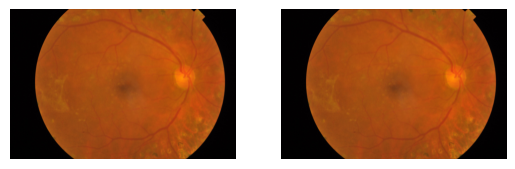

In [ ]:
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img);
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(img);

### Method 2 (Better)

In [ ]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and
    returns the a preprocessed image with
    3 channels

    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking

    :return: A NumPy array containing the cropped image
    """
    # For Grayscale images
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(axis = 1),mask.any(axis = 0))] # mask.any(axis = 1) makes a boolean array where each element in the array corresponds to each row in the image matrix. For a given row, the corresponding boolean value in the array is true if any value in the row is true.
                                                                  # mask.any(axis = 0) makes a boolean array where each element in the array corresponds to each col in the image matrix. For a given col, the corresponding boolean value in the array is true if any value in the col is true.
                                                                  # np.ix_(mask.any(axis = 1),mask.any(axis = 0)) gets those pixels from the image for which both the row and the column value is true.

    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #RGB image to grayscale
        mask = gray_img > tol #creates a boolean matrix

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # Whole image is cropped as it was too dark,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(axis = 1),mask.any(axis = 0))] #applies mask to pixel 0
            img2=img[:,:,1][np.ix_(mask.any(axis = 1),mask.any(axis = 0))]
            img3=img[:,:,2][np.ix_(mask.any(axis = 1),mask.any(axis = 0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

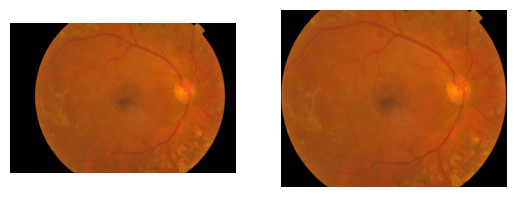

In [ ]:
path = "/content/train_images/001639a390f0.png"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img);
plt.subplot(1, 2, 2)
img_cropped = crop_image_from_gray(img)
plt.axis('off')
plt.imshow(img_cropped);

## Preprocessing pipeline

In [ ]:
def preprocess(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted (image, 4, cv2.GaussianBlur(image, (0,0) ,10), -4, 128)
    return image

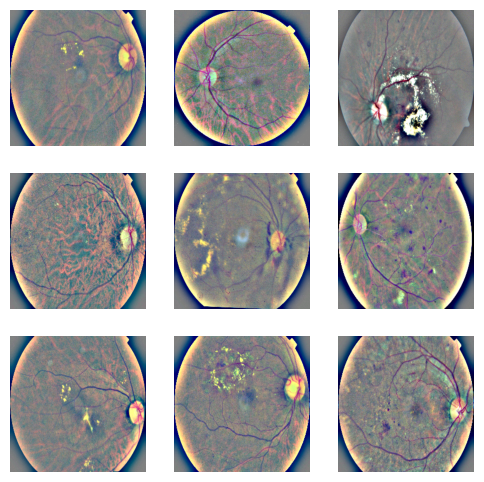

In [ ]:
import os
import cv2 # Changed 'cv' to 'cv2'

plt.figure(figsize=(6,6))
for y,x in enumerate(x_train[:9]):
    plt.subplot(3, 3, y+1)
    plt.axis('off')
    # Check if the file exists and print the path if it doesn't
    if not os.path.exists(x):
        print(f"File not found: {x}")
        continue # skip to the next image
    i = preprocess(x)
    plt.imshow(i)

# Model Training

## Making an array of train and validation images

In [ ]:
train_images = np.empty((len(x_train),IMG_SIZE,IMG_SIZE,3), dtype='uint8')
for i,path in enumerate(notebook.tqdm(x_train)):
    train_images[i] = preprocess(path)

  0%|          | 0/3112 [00:00<?, ?it/s]

In [ ]:
y_train = pd.get_dummies(y_train).values

In [ ]:
val_images = np.empty((len(x_val),IMG_SIZE,IMG_SIZE,3), dtype='uint8')
for i,path in enumerate(notebook.tqdm(x_val)):
    val_images[i] = preprocess(path)

  0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
y_val = pd.get_dummies(y_val).values

## Metric

In [ ]:
qwk = tfa.metrics.CohenKappa(5,weightage='quadratic')

## Callbacks

In [ ]:
class Save_CB(tf.keras.callbacks.Callback):
    def __init__(self,name):
        self.name = name
    def on_train_begin(self, logs={}):
        self.max = 0
    def on_epoch_end(self, epoch, logs={}):
        if logs['val_cohen_kappa'] > self.max:
            self.max = logs['val_cohen_kappa']
            print('Validation kappa improved, saving model')
            self.model.save(str(round(self.max,2))+'_'+self.name+'_.h5')

## Simple CNN

In [ ]:
cb = Save_CB('CNN')

In [ ]:
input1 = layers.Input((IMG_SIZE,IMG_SIZE,3))
x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(input1)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
output1 = layers.Dense(5,activation = 'softmax')(x)

In [ ]:
model1=tf.keras.Model(inputs=input1, outputs=output1)

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 32)                16516128  
                                                             

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[qwk]
              )

In [ ]:
history = model1.fit(train_images, y_train,
                     steps_per_epoch= len(y_train) // BATCH_SIZE,
                     epochs=10,
                     validation_data = (val_images,y_val),
                     validation_steps = len(y_val) // BATCH_SIZE,
                     callbacks = cb
                     )

Epoch 1/10
97/97 [==============================] - ETA: 0s - loss: 459.9256 - cohen_kappa: 0.4490Validation kappa improved, saving model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 16s 92ms/step - loss: 459.9256 - cohen_kappa: 0.4490 - val_loss: 5.7252 - val_cohen_kappa: 0.6235
Epoch 2/10
97/97 [==============================] - 7s 73ms/step - loss: 3.1529 - cohen_kappa: 0.6208 - val_loss: 3.0928 - val_cohen_kappa: 0.6528
Epoch 3/10
97/97 [==============================] - 6s 64ms/step - loss: 1.7744 - cohen_kappa: 0.6751 - val_loss: 3.4545 - val_cohen_kappa: 0.6268
Epoch 4/10
97/97 [==============================] - 7s 69ms/step - loss: 1.1727 - cohen_kappa: 0.7079 - val_loss: 2.9420 - val_cohen_kappa: 0.6342
Epoch 5/10
97/97 [==============================] - 6s 64ms/step - loss: 1.1947 - cohen_kappa: 0.7311 - val_loss: 2.9092 - val_cohen_kappa: 0.6312
Epoch 6/10
97/97 [==============================] - 6s 65ms/step - loss: 1.1208 - cohen_kappa: 0.7200 - val_loss: 3.0256 - val_cohen_kappa: 0.6227
Epoch 7/10
97/97 [==============================] - 6s 65ms/step - loss: 0.9457 - cohen_kappa: 0.7604 - val_loss: 5.0498 - val

97/97 [==============================] - 5s 52ms/step - loss: 0.5665 - cohen_kappa: 0.8206 - val_loss: 4.0170 - val_cohen_kappa: 0.5985


### Plots

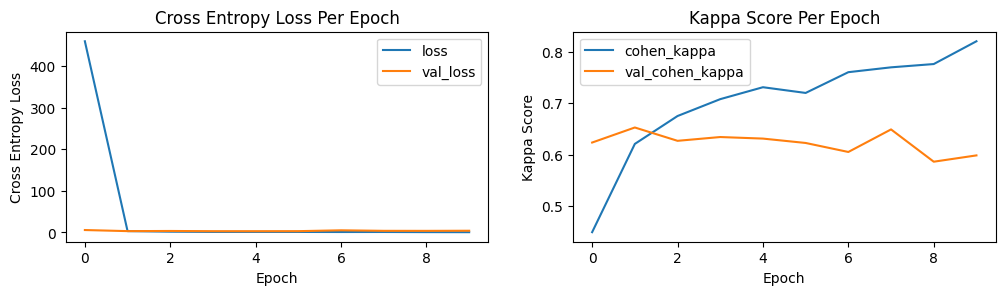

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

18/18 [==============================] - 1s 14ms/step


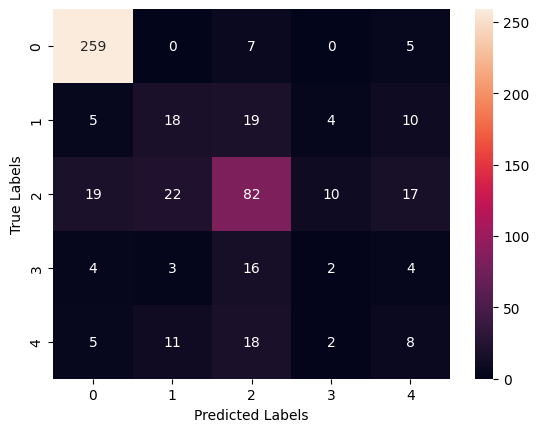

In [ ]:
y_pred = model1.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
sns.heatmap(cf_matrix, annot=True, fmt="0")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Transfer Learning

## VGG 16

In [ ]:
cb = Save_CB('VGG16')

In [ ]:
vgg16_model=VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
x = vgg16_model.output
x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
vgg16_output = layers.Dense(units=5, activation='softmax')(x)

#base_model.trainable=False

In [ ]:
model_vgg = tf.keras.Model(inputs = vgg16_model.inputs, outputs=vgg16_output)

In [ ]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[qwk]
              )

In [ ]:
history_vgg = model_vgg.fit(train_images, y_train,
                            steps_per_epoch= len(y_train) // BATCH_SIZE,
                            epochs=10,
                            validation_data = (val_images,y_val),
                            validation_steps = len(y_val) // BATCH_SIZE,
                            callbacks = cb
                           )

Epoch 1/10
97/97 [==============================] - ETA: 0s - loss: 3.2497 - cohen_kappa: 0.3492Validation kappa improved, saving model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 127s 968ms/step - loss: 3.2497 - cohen_kappa: 0.3492 - val_loss: 0.9267 - val_cohen_kappa: 0.6873
Epoch 2/10
97/97 [==============================] - 83s 856ms/step - loss: 0.9278 - cohen_kappa: 0.5901 - val_loss: 0.8557 - val_cohen_kappa: 0.6886
Epoch 3/10
97/97 [==============================] - 75s 774ms/step - loss: 0.8989 - cohen_kappa: 0.6013 - val_loss: 0.8110 - val_cohen_kappa: 0.6560
Epoch 4/10
97/97 [==============================] - 81s 834ms/step - loss: 0.8663 - cohen_kappa: 0.6353 - val_loss: 0.8039 - val_cohen_kappa: 0.7102
Epoch 5/10
97/97 [==============================] - 76s 781ms/step - loss: 0.8153 - cohen_kappa: 0.6596 - val_loss: 0.7356 - val_cohen_kappa: 0.7357
Epoch 6/10
97/97 [==============================] - 75s 776ms/step - loss: 0.7850 - cohen_kappa: 0.6839 - val_loss: 0.7013 - val_cohen_kappa: 0.7248
Epoch 7/10
97/97 [==============================] - 75s 777ms/step - loss: 0.7437 - cohen_kappa: 0.6917 - val_loss: 

Validation kappa improved, saving model
97/97 [==============================] - 72s 741ms/step - loss: 0.7057 - cohen_kappa: 0.7269 - val_loss: 0.6536 - val_cohen_kappa: 0.7594


### Plots

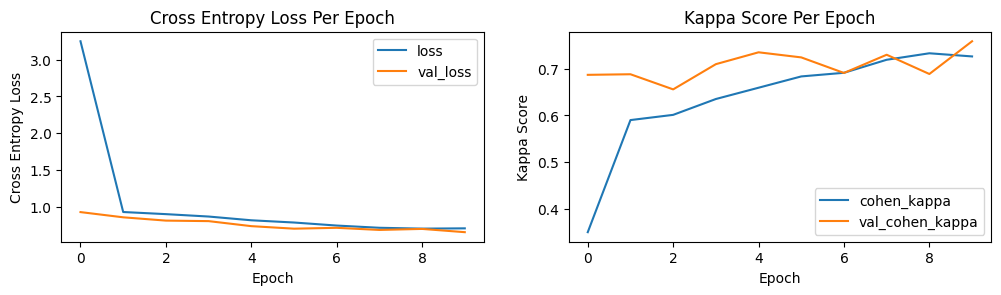

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history_vgg.history['loss'],label='loss')
plt.plot(history_vgg.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history_vgg.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history_vgg.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

18/18 [==============================] - 11s 260ms/step


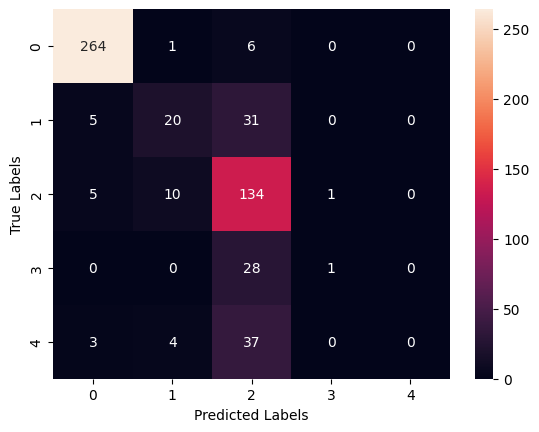

In [ ]:
y_pred = model_vgg.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
sns.heatmap(cf_matrix, annot=True, fmt="0")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

## DenseNet121

In [ ]:
cb = Save_CB('Dense121')

In [ ]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
x = densenet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
densenet_op = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_dn = tf.keras.Model(inputs = densenet.inputs, outputs=densenet_op)

In [ ]:
model_dn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']    

### Plots

In [ ]:
model_dn.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              metrics=[qwk]
              )

In [ ]:
history_dn = model_dn.fit(train_images, y_train,
                            steps_per_epoch= len(y_train) // BATCH_SIZE,
                            epochs=20,
                            validation_data = (val_images,y_val),
                            validation_steps = len(y_val) // BATCH_SIZE,
                            callbacks = cb
                           )

Epoch 1/20
97/97 [==============================] - ETA: 0s - loss: 0.9313 - cohen_kappa: 0.6972Validation kappa improved, saving model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 143s 664ms/step - loss: 0.9313 - cohen_kappa: 0.6972 - val_loss: 0.7388 - val_cohen_kappa: 0.7640
Epoch 2/20
97/97 [==============================] - 45s 467ms/step - loss: 0.5756 - cohen_kappa: 0.8263 - val_loss: 0.5669 - val_cohen_kappa: 0.7957
Epoch 3/20
97/97 [==============================] - 45s 466ms/step - loss: 0.3886 - cohen_kappa: 0.8921 - val_loss: 0.5346 - val_cohen_kappa: 0.8471
Epoch 4/20
97/97 [==============================] - 46s 471ms/step - loss: 0.3007 - cohen_kappa: 0.9254 - val_loss: 0.5743 - val_cohen_kappa: 0.8736
Epoch 5/20
97/97 [==============================] - 44s 453ms/step - loss: 0.1951 - cohen_kappa: 0.9539 - val_loss: 0.5754 - val_cohen_kappa: 0.8628
Epoch 6/20
97/97 [==============================] - 46s 471ms/step - loss: 0.1412 - cohen_kappa: 0.9675 - val_loss: 0.6739 - val_cohen_kappa: 0.8761
Epoch 7/20
97/97 [==============================] - 43s 446ms/step - loss: 0.1015 - cohen_kappa: 0.9785 - val_loss: 

97/97 [==============================] - 27s 279ms/step - loss: 0.0380 - cohen_kappa: 0.9919 - val_loss: 0.9232 - val_cohen_kappa: 0.8530


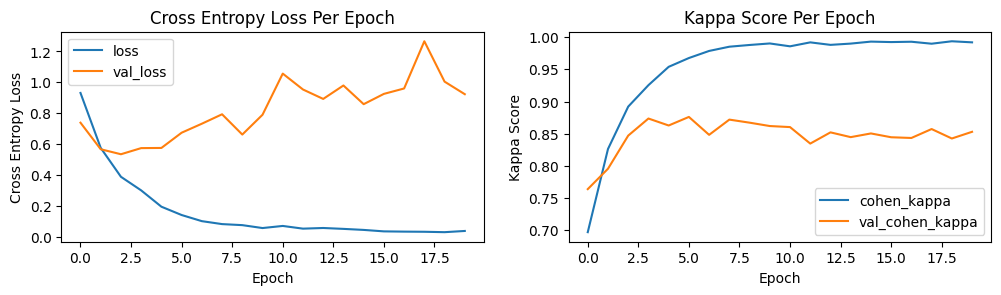

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history_dn.history['loss'],label='loss')
plt.plot(history_dn.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history_dn.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history_dn.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

18/18 [==============================] - 12s 254ms/step


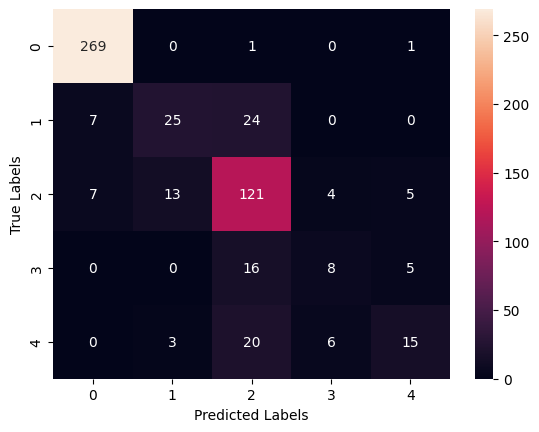

In [ ]:
y_pred = model_dn.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
sns.heatmap(cf_matrix, annot=True, fmt="0")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

## ResNet50

In [ ]:
cb = Save_CB('Resnet')

In [ ]:
resnet = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_SIZE,IMG_SIZE,3)
                 )

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
resnet_op = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_rn = tf.keras.Model(inputs = resnet.inputs, outputs=resnet_op)

In [ ]:
model_rn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
model_rn.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[qwk]
              )

In [ ]:
history_rn = model_rn.fit(train_images, y_train,
                            steps_per_epoch= len(y_train) // BATCH_SIZE,
                            epochs=15,
                            validation_data = (val_images,y_val),
                            validation_steps = len(y_val) // BATCH_SIZE,
                            callbacks = cb
                           )

Epoch 1/15
97/97 [==============================] - ETA: 0s - loss: 0.7960 - cohen_kappa: 0.7519Validation kappa improved, saving model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 96s 571ms/step - loss: 0.7960 - cohen_kappa: 0.7519 - val_loss: 18655.1758 - val_cohen_kappa: 0.0092
Epoch 2/15
97/97 [==============================] - 41s 420ms/step - loss: 0.5631 - cohen_kappa: 0.8384 - val_loss: 6940.5508 - val_cohen_kappa: 0.0046
Epoch 3/15
97/97 [==============================] - 41s 422ms/step - loss: 0.5348 - cohen_kappa: 0.8558 - val_loss: 7074.6260 - val_cohen_kappa: 0.0000e+00
Epoch 4/15
97/97 [==============================] - 46s 477ms/step - loss: 0.4844 - cohen_kappa: 0.8741 - val_loss: 0.8815 - val_cohen_kappa: 0.8255
Epoch 5/15
97/97 [==============================] - 40s 417ms/step - loss: 0.3881 - cohen_kappa: 0.9002 - val_loss: 0.9924 - val_cohen_kappa: 0.7490
Epoch 6/15
97/97 [==============================] - 41s 421ms/step - loss: 0.3319 - cohen_kappa: 0.9279 - val_loss: 1.8094 - val_cohen_kappa: 0.6200
Epoch 7/15
97/97 [==============================] - 41s 421ms/step - loss: 0.2902 - cohen_kappa: 0.9342

97/97 [==============================] - 29s 293ms/step - loss: 0.0767 - cohen_kappa: 0.9869 - val_loss: 1.2312 - val_cohen_kappa: 0.7813


### Plots

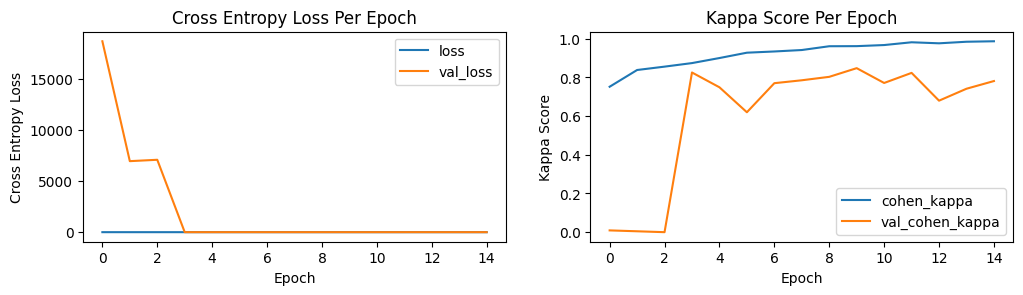

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history_rn.history['loss'],label='loss')
plt.plot(history_rn.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history_rn.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history_rn.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

18/18 [==============================] - 6s 167ms/step


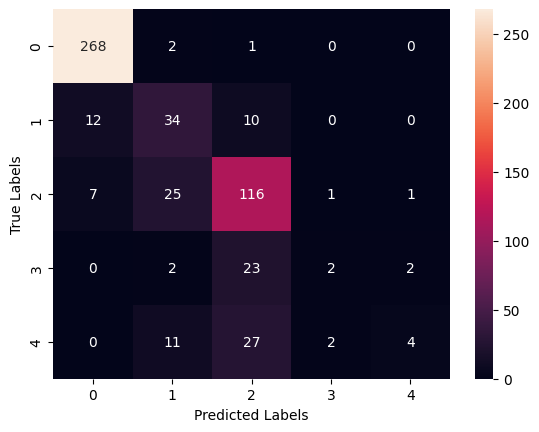

In [ ]:
y_pred = model_rn.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
sns.heatmap(cf_matrix, annot=True, fmt="0")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

## InceptionNetV3

In [ ]:
cb = Save_CB('Incnet')

In [ ]:
incnet = InceptionV3(weights='imagenet',
                     include_top=False,
                     input_shape=(IMG_SIZE,IMG_SIZE,3)
                    )

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
x = incnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
incnet_op = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_in = tf.keras.Model(inputs = incnet.inputs, outputs=incnet_op)

In [ ]:
model_in.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 127, 127, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0]

In [ ]:
model_in.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              metrics=[qwk]
              )

In [ ]:
history_in = model_in.fit(train_images, y_train,
                            steps_per_epoch= len(y_train) // BATCH_SIZE,
                            epochs=15,
                            validation_data = (val_images,y_val),
                            validation_steps = len(y_val) // BATCH_SIZE,
                            callbacks = cb
                           )

Epoch 1/15
97/97 [==============================] - ETA: 0s - loss: 0.7220 - cohen_kappa: 0.7427Validation kappa improved, saving model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 118s 742ms/step - loss: 0.7220 - cohen_kappa: 0.7427 - val_loss: 0.8105 - val_cohen_kappa: 0.7768
Epoch 2/15
97/97 [==============================] - 39s 402ms/step - loss: 0.4341 - cohen_kappa: 0.8779 - val_loss: 0.6810 - val_cohen_kappa: 0.8559
Epoch 3/15
97/97 [==============================] - 33s 339ms/step - loss: 0.2729 - cohen_kappa: 0.9309 - val_loss: 0.7795 - val_cohen_kappa: 0.7824
Epoch 4/15
97/97 [==============================] - 40s 412ms/step - loss: 0.1822 - cohen_kappa: 0.9607 - val_loss: 0.7789 - val_cohen_kappa: 0.8702
Epoch 5/15
97/97 [==============================] - 34s 346ms/step - loss: 0.1278 - cohen_kappa: 0.9725 - val_loss: 0.7823 - val_cohen_kappa: 0.8242
Epoch 6/15
97/97 [==============================] - 34s 347ms/step - loss: 0.0799 - cohen_kappa: 0.9817 - val_loss: 0.9296 - val_cohen_kappa: 0.7986
Epoch 7/15
97/97 [==============================] - 32s 332ms/step - loss: 0.1455 - cohen_kappa: 0.9620 - val_loss: 

97/97 [==============================] - 23s 238ms/step - loss: 0.1124 - cohen_kappa: 0.9670 - val_loss: 1.5199 - val_cohen_kappa: 0.3286


### Plots

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history_in.history['loss'],label='loss')
plt.plot(history_in.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history_in.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history_in.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

In [ ]:
y_pred = model_in.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
sns.heatmap(cf_matrix, annot=True, fmt="0")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

## EfficientNetB3

In [ ]:
cb = Save_CB('Effcnet')

In [ ]:
effnet = EfficientNetB3(weights='imagenet',
                     include_top=False,
                     input_shape=(IMG_SIZE,IMG_SIZE,3)
                    )

In [ ]:
x = effnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
effnet_op = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_en = tf.keras.Model(inputs = effnet.inputs, outputs=effnet_op)

In [ ]:
model_en.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=[qwk]
              )

In [ ]:
history_en = model_en.fit(train_images, y_train,
                            steps_per_epoch= len(y_train) // BATCH_SIZE,
                            epochs=15,
                            validation_data = (val_images,y_val),
                            validation_steps = len(y_val) // BATCH_SIZE,
                            callbacks = cb
                           )

Epoch 1/15
97/97 [==============================] - ETA: 0s - loss: 0.8341 - cohen_kappa: 0.5792Validation kappa improved, saving model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


97/97 [==============================] - 147s 853ms/step - loss: 0.8341 - cohen_kappa: 0.5792 - val_loss: 0.6626 - val_cohen_kappa: 0.7491
Epoch 2/15
97/97 [==============================] - 72s 741ms/step - loss: 0.4954 - cohen_kappa: 0.8378 - val_loss: 0.6098 - val_cohen_kappa: 0.8207
Epoch 3/15
97/97 [==============================] - 67s 688ms/step - loss: 0.3514 - cohen_kappa: 0.9062 - val_loss: 0.5969 - val_cohen_kappa: 0.8525
Epoch 4/15
97/97 [==============================] - 71s 734ms/step - loss: 0.2402 - cohen_kappa: 0.9431 - val_loss: 0.6216 - val_cohen_kappa: 0.8847
Epoch 5/15
97/97 [==============================] - 65s 675ms/step - loss: 0.1660 - cohen_kappa: 0.9645 - val_loss: 0.6465 - val_cohen_kappa: 0.8775
Epoch 6/15
97/97 [==============================] - 66s 677ms/step - loss: 0.1282 - cohen_kappa: 0.9716 - val_loss: 0.7100 - val_cohen_kappa: 0.8813
Epoch 7/15
97/97 [==============================] - 65s 672ms/step - loss: 0.0903 - cohen_kappa: 0.9836 - val_loss: 

97/97 [==============================] - 46s 472ms/step - loss: 0.0626 - cohen_kappa: 0.9885 - val_loss: 0.8982 - val_cohen_kappa: 0.8519


### Plots

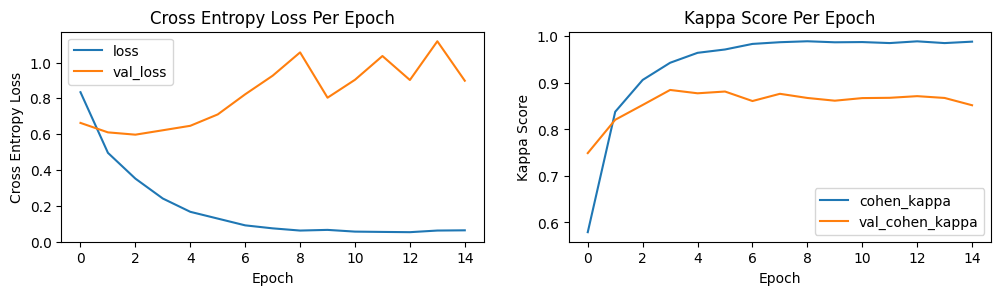

In [ ]:
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
plt.plot(history_en.history['loss'],label='loss')
plt.plot(history_en.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.title('Cross Entropy Loss Per Epoch')

plt.subplot(2,2,2)
plt.plot(history_en.history['cohen_kappa'],label='cohen_kappa')
plt.plot(history_en.history['val_cohen_kappa'],label='val_cohen_kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa Score')
plt.title('Kappa Score Per Epoch')
plt.legend()

plt.show()

18/18 [==============================] - 8s 210ms/step


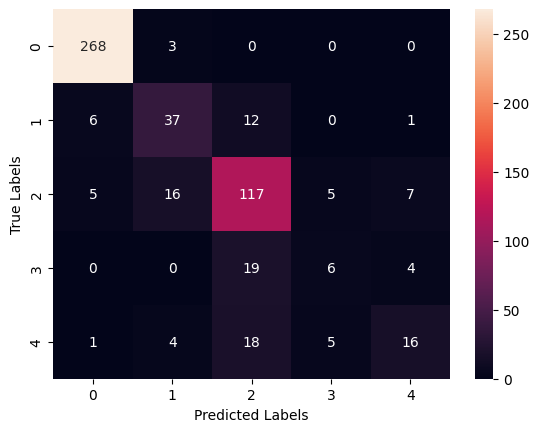

In [ ]:
y_pred = model_en.predict(val_images)
cf_matrix = confusion_matrix([np.argmax(x) for x in y_val], [np.argmax(x) for x in y_pred])
sns.heatmap(cf_matrix, annot=True, fmt="0")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

## Summary

In [ ]:
pt = PrettyTable()

In [ ]:
pt.field_names = ['Model','Val Loss','Val Kappa']
pt.add_row(["Baseline", min(history.history['val_loss']), max(history.history['val_cohen_kappa'])])
pt.add_row(["VGG16", min(history_vgg.history['val_loss']), max(history_vgg.history['val_cohen_kappa'])])
pt.add_row(["DenseNet121", min(history_dn.history['val_loss']), max(history_dn.history['val_cohen_kappa'])])
pt.add_row(["ResNet50", min(history_rn.history['val_loss']), max(history_rn.history['val_cohen_kappa'])])
pt.add_row(["InceptionV3", min(history_in.history['val_loss']), max(history_in.history['val_cohen_kappa'])])
pt.add_row(["EfficientNetB5", min(history_en.history['val_loss']), max(history_en.history['val_cohen_kappa'])])

In [ ]:
print(pt)

+----------------+--------------------+--------------------+
|     Model      |      Val Loss      |     Val Kappa      |
+----------------+--------------------+--------------------+
|    Baseline    | 2.9092183113098145 | 0.6527615785598755 |
|     VGG16      | 0.6536343097686768 | 0.7594451904296875 |
|  DenseNet121   | 0.5346042513847351 | 0.8761098384857178 |
|    ResNet50    | 0.8636572957038879 | 0.8479255437850952 |
|  InceptionV3   | 0.680952787399292  | 0.8702281713485718 |
| EfficientNetB5 | 0.5969048142433167 |  0.88472580909729  |
+----------------+--------------------+--------------------+
